In [3]:
import os
import numpy as np
import pandas as pd
from pathlib import Path

import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_curve, auc,
    confusion_matrix, ConfusionMatrixDisplay, f1_score
)
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from joblib import dump

def load_trimmed_sequences(data_dir, sequence_length=10):
    """
    Load pre-trimmed joint-coordinate CSVs and return:
      X: ndarray (n_samples, sequence_length, 39)
      y: ndarray (n_samples,) integer labels (1=Good, 0=Bad)
    """
    data_dir = Path(data_dir)
    paths = sorted(data_dir.glob("[GW]*_trimmed.csv"))

    X_list, y_list = [], []
    for p in paths:
        stem = p.stem
        if stem.startswith("G"):
            label = 1
        elif stem.startswith("W"):
            label = 0
        else:
            continue  # ignore unexpected files

        df = pd.read_csv(p)
        df = df.drop(columns=["FrameNo"], errors="ignore")
        seq = df.values
        F, D = seq.shape

        # sample or pad to fixed length
        if F >= sequence_length:
            idx = np.linspace(0, F - 1, sequence_length, dtype=int)
            proc_seq = seq[idx]
        else:
            pad = np.zeros((sequence_length - F, D), dtype=seq.dtype)
            proc_seq = np.vstack([seq, pad])

        X_list.append(proc_seq)
        y_list.append(label)

    X = np.stack(X_list, axis=0)
    y = np.array(y_list, dtype=int)
    return X, y


def build_dense(n_hidden_layers=2, param_budget=10_000, input_shape=(10, 39)):
    """
    Build and compile a Sequential dense model targeting ~param_budget parameters.

    Returns a tf.keras.Model.
    """
    D = np.prod(input_shape)
    L = n_hidden_layers

    # solve for hidden units per layer
    if L == 1:
        h = int((param_budget - 1) / (D + 1))
    else:
        a, b, c = (L-1), (D+L+1), (1 - param_budget)
        disc = b*b - 4*a*c
        h = int((-b + np.sqrt(disc)) / (2*a))
    h = max(1, h)

    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Flatten(),
        *[layers.Dense(h, activation="relu") for _ in range(L)],
        layers.Dense(1, activation="sigmoid")
    ])
    model.compile(
        optimizer="adam",
        loss="binary_crossentropy",
        metrics=[
            tf.keras.metrics.BinaryAccuracy(name="accuracy"),
            tf.keras.metrics.Precision(name="precision"),
            tf.keras.metrics.Recall(name="recall"),
            tf.keras.metrics.AUC(name="auc"),
        ],
    )
    return model


def cross_validate_dense(
    X, y,
    n_hidden_layers,
    param_budget=10_000,
    n_splits=5,
    epochs=50,
    batch_size=32,
    patience=10,
    input_shape=(10,39),
    random_state=42
):
    """
    Stratified K-Fold CV for the dense model.

    Returns:
      fold_metrics: list of (loss, accuracy, precision, recall, f1, auc)
      histories:    list of history.history dicts
      y_trues:      list of true-label arrays per fold
      y_preds:      list of predicted-label arrays per fold
      y_probs:      list of predicted-prob arrays per fold
    """
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    fold_metrics, histories = [], []
    y_trues, y_preds, y_probs = [], [], []

    for train_i, test_i in skf.split(X, y):
        # split and scale
        X_tr_raw, X_val_raw = X[train_i], X[test_i]
        y_tr, y_val         = y[train_i], y[test_i]
        flat_tr = X_tr_raw.reshape(-1, X.shape[-1])
        flat_val = X_val_raw.reshape(-1, X.shape[-1])
        scaler = StandardScaler().fit(flat_tr)
        X_tr = scaler.transform(flat_tr).reshape(X_tr_raw.shape)
        X_val = scaler.transform(flat_val).reshape(X_val_raw.shape)

        # build & fit
        model = build_dense(n_hidden_layers, param_budget, input_shape)
        es = EarlyStopping(monitor="val_loss", patience=patience, restore_best_weights=True)
        history = model.fit(
            X_tr, y_tr,
            validation_data=(X_val, y_val),
            epochs=epochs, batch_size=batch_size,
            verbose=0, callbacks=[es]
        )
        model.summary()

        # predict & compute metrics
        y_prob = model.predict(X_val, verbose=0).ravel()
        y_pred = (y_prob >= 0.5).astype(int)
        f1 = f1_score(y_val, y_pred)

        loss, acc, prec, rec, auc_val = model.evaluate(X_val, y_val, verbose=0)
        fold_metrics.append((loss, acc, prec, rec, f1, auc_val))
        histories.append(history.history)

        y_trues.append(y_val)
        y_preds.append(y_pred)
        y_probs.append(y_prob)

    return fold_metrics, histories, y_trues, y_preds, y_probs


def plot_average_loss(histories, ax=None, title_prefix="Average Loss"):
    """Plot mean train & val loss over folds."""
    if ax is None: ax = plt.gca()
    min_e = min(len(h["loss"]) for h in histories)
    x = range(1, min_e+1)
    train = np.array([h["loss"][:min_e]     for h in histories]).mean(0)
    val   = np.array([h["val_loss"][:min_e] for h in histories]).mean(0)

    ax.plot(x, train, label="Train Loss")
    ax.plot(x, val,   label="Val Loss")
    ax.set(xlabel="Epoch", ylabel="Loss", title=f"{title_prefix} over {len(histories)} folds")
    ax.legend()


def plot_average_precision_recall(histories, ax=None, title_prefix="Avg Precision & Recall"):
    """Plot mean train & val precision/recall over folds."""
    if ax is None: ax = plt.gca()
    min_e = min(len(h["precision"]) for h in histories)
    x = range(1, min_e+1)
    tprec = np.array([h["precision"][:min_e]    for h in histories]).mean(0)
    vprec = np.array([h["val_precision"][:min_e] for h in histories]).mean(0)
    trec  = np.array([h["recall"][:min_e]       for h in histories]).mean(0)
    vrec  = np.array([h["val_recall"][:min_e]    for h in histories]).mean(0)

    ax.plot(x, tprec, label="Train Precision")
    ax.plot(x, vprec, label="Val Precision")
    ax.plot(x, trec,  label="Train Recall")
    ax.plot(x, vrec,  label="Val Recall")
    ax.set(xlabel="Epoch", ylabel="Metric", title=f"{title_prefix} over {len(histories)} folds")
    ax.legend()


def plot_aggregated_roc(y_trues, y_probs, ax=None, title="ROC Curve"):
    """Plot one ROC/AUC over all folds combined."""
    if ax is None: ax = plt.gca()
    y_true_all = np.concatenate(y_trues)
    y_prob_all = np.concatenate(y_probs)
    fpr, tpr, _ = roc_curve(y_true_all, y_prob_all)
    roc_auc = auc(fpr, tpr)

    ax.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
    ax.plot([0,1], [0,1], "k--", label="Chance")
    ax.set(xlabel="False Positive Rate", ylabel="True Positive Rate", title=title)
    ax.legend()


def plot_confusion_matrix(y_trues, y_preds, ax=None, labels=('Bad','Good'), title="Confusion Matrix"):
    """Plot aggregated confusion matrix over all folds."""
    if ax is None: ax = plt.gca()
    cms = [confusion_matrix(t, p) for t, p in zip(y_trues, y_preds)]
    total_cm = sum(cms)
    disp = ConfusionMatrixDisplay(total_cm, display_labels=labels)
    disp.plot(ax=ax, cmap=plt.cm.Blues)
    ax.set_title(title)


def plot_cv_summary(histories, y_trues, y_preds, y_probs, depth, params):
    """
    2×2 summary: Loss, Precision/Recall, ROC & Confusion Matrix.
    """
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))
    plot_average_loss(histories,                ax=axs[0,0])
    plot_average_precision_recall(histories,    ax=axs[0,1])
    plot_aggregated_roc(y_trues, y_probs,       ax=axs[1,0])
    plot_confusion_matrix(y_trues, y_preds,     ax=axs[1,1])
    fig.suptitle(f"{depth}-layer model (~{params} params)", fontsize=16)
    plt.tight_layout()
    plt.show()


def print_results(fold_metrics, metric_names=None):
    """
    Print mean of each metric across folds.
    fold_metrics tuples: (loss, accuracy, precision, recall, f1, auc)
    """
    if metric_names is None:
        metric_names = ["bce_loss","accuracy","precision","recall","f1_score","auc"]
    mean_vals = {
        name: np.mean([fm[i] for fm in fold_metrics])
        for i, name in enumerate(metric_names)
    }
    print("Mean CV metrics:")
    for name in metric_names:
        print(f"  {name.title():<9}: {mean_vals[name]:.4f}")


X, y = load_trimmed_sequences("data/kinect_good_vs_bad_trimmed", sequence_length=10)

EPOCHS = 50
BATCH_SIZE = 32
PATIENCE = 10

In [4]:
# Sweep over depths and compute mean CV accuracy
depths = range(1, 11)
mean_accuracies = []

for L in depths:
    fold_metrics, _, _, _, _ = cross_validate_dense(
        X, y,
        n_hidden_layers=L,
        param_budget=10_000,
        n_splits=5,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        patience=PATIENCE
    )
    # accuracy is at index 1
    accuracies = [m[1] for m in fold_metrics]
    mean_accuracies.append(np.mean(accuracies))

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 390)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         9,775 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,405 (114.87 KB)

 Trainable params: 9,801 (38.29 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 19,604 (76.58 KB)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 390)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 25)             │         9,775 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,405 (114.87 KB)

 Trainable params: 9,801 (38.29 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 19,604 (76.58 KB)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)             │ (None, 390)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 25)             │         9,775 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,405 (114.87 KB)

 Trainable params: 9,801 (38.29 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 19,604 (76.58 KB)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_3 (Flatten)             │ (None, 390)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 25)             │         9,775 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,405 (114.87 KB)

 Trainable params: 9,801 (38.29 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 19,604 (76.58 KB)

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_4 (Flatten)             │ (None, 390)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 25)             │         9,775 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,405 (114.87 KB)

 Trainable params: 9,801 (38.29 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 19,604 (76.58 KB)

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_5 (Flatten)             │ (None, 390)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 23)             │         8,993 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 23)             │           552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │            24 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,709 (112.15 KB)

 Trainable params: 9,569 (37.38 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 19,140 (74.77 KB)

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_6 (Flatten)             │ (None, 390)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 23)             │         8,993 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 23)             │           552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            24 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,709 (112.15 KB)

 Trainable params: 9,569 (37.38 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 19,140 (74.77 KB)

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_7 (Flatten)             │ (None, 390)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 23)             │         8,993 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 23)             │           552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 1)              │            24 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,709 (112.15 KB)

 Trainable params: 9,569 (37.38 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 19,140 (74.77 KB)

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_8 (Flatten)             │ (None, 390)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 23)             │         8,993 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 23)             │           552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │            24 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,709 (112.15 KB)

 Trainable params: 9,569 (37.38 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 19,140 (74.77 KB)

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_9 (Flatten)             │ (None, 390)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 23)             │         8,993 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 23)             │           552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 1)              │            24 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,709 (112.15 KB)

 Trainable params: 9,569 (37.38 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 19,140 (74.77 KB)

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_10 (Flatten)            │ (None, 390)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 22)             │         8,602 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 22)             │           506 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 22)             │           506 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 1)              │            23 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,913 (112.95 KB)

 Trainable params: 9,637 (37.64 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 19,276 (75.30 KB)

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_11 (Flatten)            │ (None, 390)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 22)             │         8,602 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 22)             │           506 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 22)             │           506 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 1)              │            23 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,913 (112.95 KB)

 Trainable params: 9,637 (37.64 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 19,276 (75.30 KB)

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_12 (Flatten)            │ (None, 390)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 22)             │         8,602 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 22)             │           506 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 22)             │           506 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 1)              │            23 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,913 (112.95 KB)

 Trainable params: 9,637 (37.64 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 19,276 (75.30 KB)

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_13 (Flatten)            │ (None, 390)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 22)             │         8,602 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 22)             │           506 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 22)             │           506 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 1)              │            23 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,913 (112.95 KB)

 Trainable params: 9,637 (37.64 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 19,276 (75.30 KB)

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_14 (Flatten)            │ (None, 390)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 22)             │         8,602 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 22)             │           506 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 22)             │           506 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 1)              │            23 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,913 (112.95 KB)

 Trainable params: 9,637 (37.64 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 19,276 (75.30 KB)

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_15 (Flatten)            │ (None, 390)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 21)             │         8,211 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 21)             │           462 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 21)             │           462 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 21)             │           462 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 1)              │            22 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,859 (112.73 KB)

 Trainable params: 9,619 (37.57 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 19,240 (75.16 KB)

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_16 (Flatten)            │ (None, 390)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 21)             │         8,211 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 21)             │           462 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 21)             │           462 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 21)             │           462 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 1)              │            22 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,859 (112.73 KB)

 Trainable params: 9,619 (37.57 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 19,240 (75.16 KB)

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_17 (Flatten)            │ (None, 390)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 21)             │         8,211 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 21)             │           462 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 21)             │           462 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ (None, 21)             │           462 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ (None, 1)              │            22 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,859 (112.73 KB)

 Trainable params: 9,619 (37.57 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 19,240 (75.16 KB)

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_18 (Flatten)            │ (None, 390)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ (None, 21)             │         8,211 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 21)             │           462 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 21)             │           462 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_63 (Dense)                │ (None, 21)             │           462 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_64 (Dense)                │ (None, 1)              │            22 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,859 (112.73 KB)

 Trainable params: 9,619 (37.57 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 19,240 (75.16 KB)

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_19 (Flatten)            │ (None, 390)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_65 (Dense)                │ (None, 21)             │         8,211 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_66 (Dense)                │ (None, 21)             │           462 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_67 (Dense)                │ (None, 21)             │           462 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_68 (Dense)                │ (None, 21)             │           462 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_69 (Dense)                │ (None, 1)              │            22 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,859 (112.73 KB)

 Trainable params: 9,619 (37.57 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 19,240 (75.16 KB)

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_20 (Flatten)            │ (None, 390)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_70 (Dense)                │ (None, 20)             │         7,820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_71 (Dense)                │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_72 (Dense)                │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_73 (Dense)                │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_74 (Dense)                │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_75 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,565 (111.59 KB)

 Trainable params: 9,521 (37.19 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 19,044 (74.39 KB)

Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_21 (Flatten)            │ (None, 390)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_76 (Dense)                │ (None, 20)             │         7,820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_77 (Dense)                │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_78 (Dense)                │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_79 (Dense)                │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_80 (Dense)                │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_81 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,565 (111.59 KB)

 Trainable params: 9,521 (37.19 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 19,044 (74.39 KB)

Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_22 (Flatten)            │ (None, 390)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_82 (Dense)                │ (None, 20)             │         7,820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_83 (Dense)                │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_84 (Dense)                │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_85 (Dense)                │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_86 (Dense)                │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_87 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,565 (111.59 KB)

 Trainable params: 9,521 (37.19 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 19,044 (74.39 KB)

Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_23 (Flatten)            │ (None, 390)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_88 (Dense)                │ (None, 20)             │         7,820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_89 (Dense)                │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_90 (Dense)                │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_91 (Dense)                │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_92 (Dense)                │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_93 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,565 (111.59 KB)

 Trainable params: 9,521 (37.19 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 19,044 (74.39 KB)

Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_24 (Flatten)            │ (None, 390)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_94 (Dense)                │ (None, 20)             │         7,820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_95 (Dense)                │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_96 (Dense)                │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_97 (Dense)                │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_98 (Dense)                │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_99 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,565 (111.59 KB)

 Trainable params: 9,521 (37.19 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 19,044 (74.39 KB)

Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_25 (Flatten)            │ (None, 390)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_100 (Dense)               │ (None, 20)             │         7,820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_101 (Dense)               │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_102 (Dense)               │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_103 (Dense)               │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_104 (Dense)               │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_105 (Dense)               │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_106 (Dense)               │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,825 (116.51 KB)

 Trainable params: 9,941 (38.83 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 19,884 (77.68 KB)

Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_26 (Flatten)            │ (None, 390)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_107 (Dense)               │ (None, 20)             │         7,820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_108 (Dense)               │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_109 (Dense)               │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_110 (Dense)               │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_111 (Dense)               │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_112 (Dense)               │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_113 (Dense)               │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,825 (116.51 KB)

 Trainable params: 9,941 (38.83 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 19,884 (77.68 KB)

Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_27 (Flatten)            │ (None, 390)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_114 (Dense)               │ (None, 20)             │         7,820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_115 (Dense)               │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_116 (Dense)               │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_117 (Dense)               │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_118 (Dense)               │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_119 (Dense)               │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_120 (Dense)               │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,825 (116.51 KB)

 Trainable params: 9,941 (38.83 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 19,884 (77.68 KB)

Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_28 (Flatten)            │ (None, 390)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_121 (Dense)               │ (None, 20)             │         7,820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_122 (Dense)               │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_123 (Dense)               │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_124 (Dense)               │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_125 (Dense)               │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_126 (Dense)               │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_127 (Dense)               │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,825 (116.51 KB)

 Trainable params: 9,941 (38.83 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 19,884 (77.68 KB)

Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_29 (Flatten)            │ (None, 390)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_128 (Dense)               │ (None, 20)             │         7,820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_129 (Dense)               │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_130 (Dense)               │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_131 (Dense)               │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_132 (Dense)               │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_133 (Dense)               │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_134 (Dense)               │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,825 (116.51 KB)

 Trainable params: 9,941 (38.83 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 19,884 (77.68 KB)

Model: "sequential_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_30 (Flatten)            │ (None, 390)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_135 (Dense)               │ (None, 19)             │         7,429 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_136 (Dense)               │ (None, 19)             │           380 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_137 (Dense)               │ (None, 19)             │           380 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_138 (Dense)               │ (None, 19)             │           380 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_139 (Dense)               │ (None, 19)             │           380 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_140 (Dense)               │ (None, 19)             │           380 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_141 (Dense)               │ (None, 19)             │           380 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_142 (Dense)               │ (None, 1)              │            20 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,189 (114.02 KB)

 Trainable params: 9,729 (38.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 19,460 (76.02 KB)

Model: "sequential_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_31 (Flatten)            │ (None, 390)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_143 (Dense)               │ (None, 19)             │         7,429 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_144 (Dense)               │ (None, 19)             │           380 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_145 (Dense)               │ (None, 19)             │           380 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_146 (Dense)               │ (None, 19)             │           380 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_147 (Dense)               │ (None, 19)             │           380 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_148 (Dense)               │ (None, 19)             │           380 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_149 (Dense)               │ (None, 19)             │           380 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_150 (Dense)               │ (None, 1)              │            20 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,189 (114.02 KB)

 Trainable params: 9,729 (38.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 19,460 (76.02 KB)

Model: "sequential_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_32 (Flatten)            │ (None, 390)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_151 (Dense)               │ (None, 19)             │         7,429 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_152 (Dense)               │ (None, 19)             │           380 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_153 (Dense)               │ (None, 19)             │           380 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_154 (Dense)               │ (None, 19)             │           380 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_155 (Dense)               │ (None, 19)             │           380 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_156 (Dense)               │ (None, 19)             │           380 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_157 (Dense)               │ (None, 19)             │           380 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_158 (Dense)               │ (None, 1)              │            20 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,189 (114.02 KB)

 Trainable params: 9,729 (38.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 19,460 (76.02 KB)

Model: "sequential_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_33 (Flatten)            │ (None, 390)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_159 (Dense)               │ (None, 19)             │         7,429 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_160 (Dense)               │ (None, 19)             │           380 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_161 (Dense)               │ (None, 19)             │           380 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_162 (Dense)               │ (None, 19)             │           380 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_163 (Dense)               │ (None, 19)             │           380 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_164 (Dense)               │ (None, 19)             │           380 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_165 (Dense)               │ (None, 19)             │           380 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_166 (Dense)               │ (None, 1)              │            20 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,189 (114.02 KB)

 Trainable params: 9,729 (38.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 19,460 (76.02 KB)

Model: "sequential_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_34 (Flatten)            │ (None, 390)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_167 (Dense)               │ (None, 19)             │         7,429 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_168 (Dense)               │ (None, 19)             │           380 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_169 (Dense)               │ (None, 19)             │           380 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_170 (Dense)               │ (None, 19)             │           380 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_171 (Dense)               │ (None, 19)             │           380 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_172 (Dense)               │ (None, 19)             │           380 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_173 (Dense)               │ (None, 19)             │           380 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_174 (Dense)               │ (None, 1)              │            20 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,189 (114.02 KB)

 Trainable params: 9,729 (38.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 19,460 (76.02 KB)

Model: "sequential_35"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_35 (Flatten)            │ (None, 390)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_175 (Dense)               │ (None, 18)             │         7,038 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_176 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_177 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_178 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_179 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_180 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_181 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_182 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_183 (Dense)               │ (None, 1)              │            19 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,355 (110.77 KB)

 Trainable params: 9,451 (36.92 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 18,904 (73.85 KB)

Model: "sequential_36"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_36 (Flatten)            │ (None, 390)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_184 (Dense)               │ (None, 18)             │         7,038 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_185 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_186 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_187 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_188 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_189 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_190 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_191 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_192 (Dense)               │ (None, 1)              │            19 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,355 (110.77 KB)

 Trainable params: 9,451 (36.92 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 18,904 (73.85 KB)

Model: "sequential_37"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_37 (Flatten)            │ (None, 390)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_193 (Dense)               │ (None, 18)             │         7,038 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_194 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_195 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_196 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_197 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_198 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_199 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_200 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_201 (Dense)               │ (None, 1)              │            19 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,355 (110.77 KB)

 Trainable params: 9,451 (36.92 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 18,904 (73.85 KB)

Model: "sequential_38"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_38 (Flatten)            │ (None, 390)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_202 (Dense)               │ (None, 18)             │         7,038 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_203 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_204 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_205 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_206 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_207 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_208 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_209 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_210 (Dense)               │ (None, 1)              │            19 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,355 (110.77 KB)

 Trainable params: 9,451 (36.92 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 18,904 (73.85 KB)

Model: "sequential_39"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_39 (Flatten)            │ (None, 390)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_211 (Dense)               │ (None, 18)             │         7,038 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_212 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_213 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_214 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_215 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_216 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_217 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_218 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_219 (Dense)               │ (None, 1)              │            19 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,355 (110.77 KB)

 Trainable params: 9,451 (36.92 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 18,904 (73.85 KB)

Model: "sequential_40"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_40 (Flatten)            │ (None, 390)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_220 (Dense)               │ (None, 18)             │         7,038 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_221 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_222 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_223 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_224 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_225 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_226 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_227 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_228 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_229 (Dense)               │ (None, 1)              │            19 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,381 (114.77 KB)

 Trainable params: 9,793 (38.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 19,588 (76.52 KB)

Model: "sequential_41"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_41 (Flatten)            │ (None, 390)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_230 (Dense)               │ (None, 18)             │         7,038 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_231 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_232 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_233 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_234 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_235 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_236 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_237 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_238 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_239 (Dense)               │ (None, 1)              │            19 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,381 (114.77 KB)

 Trainable params: 9,793 (38.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 19,588 (76.52 KB)

Model: "sequential_42"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_42 (Flatten)            │ (None, 390)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_240 (Dense)               │ (None, 18)             │         7,038 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_241 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_242 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_243 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_244 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_245 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_246 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_247 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_248 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_249 (Dense)               │ (None, 1)              │            19 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,381 (114.77 KB)

 Trainable params: 9,793 (38.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 19,588 (76.52 KB)

Model: "sequential_43"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_43 (Flatten)            │ (None, 390)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_250 (Dense)               │ (None, 18)             │         7,038 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_251 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_252 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_253 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_254 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_255 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_256 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_257 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_258 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_259 (Dense)               │ (None, 1)              │            19 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,381 (114.77 KB)

 Trainable params: 9,793 (38.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 19,588 (76.52 KB)

Model: "sequential_44"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_44 (Flatten)            │ (None, 390)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_260 (Dense)               │ (None, 18)             │         7,038 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_261 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_262 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_263 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_264 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_265 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_266 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_267 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_268 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_269 (Dense)               │ (None, 1)              │            19 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,381 (114.77 KB)

 Trainable params: 9,793 (38.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 19,588 (76.52 KB)

Model: "sequential_45"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_45 (Flatten)            │ (None, 390)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_270 (Dense)               │ (None, 17)             │         6,647 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_271 (Dense)               │ (None, 17)             │           306 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_272 (Dense)               │ (None, 17)             │           306 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_273 (Dense)               │ (None, 17)             │           306 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_274 (Dense)               │ (None, 17)             │           306 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_275 (Dense)               │ (None, 17)             │           306 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_276 (Dense)               │ (None, 17)             │           306 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_277 (Dense)               │ (None, 17)             │           306 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_278 (Dense)               │ (None, 17)             │           306 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_279 (Dense)               │ (None, 17)             │           306 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_280 (Dense)               │ (None, 1)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,259 (110.39 KB)

 Trainable params: 9,419 (36.79 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 18,840 (73.60 KB)

Model: "sequential_46"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_46 (Flatten)            │ (None, 390)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_281 (Dense)               │ (None, 17)             │         6,647 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_282 (Dense)               │ (None, 17)             │           306 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_283 (Dense)               │ (None, 17)             │           306 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_284 (Dense)               │ (None, 17)             │           306 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_285 (Dense)               │ (None, 17)             │           306 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_286 (Dense)               │ (None, 17)             │           306 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_287 (Dense)               │ (None, 17)             │           306 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_288 (Dense)               │ (None, 17)             │           306 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_289 (Dense)               │ (None, 17)             │           306 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_290 (Dense)               │ (None, 17)             │           306 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_291 (Dense)               │ (None, 1)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,259 (110.39 KB)

 Trainable params: 9,419 (36.79 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 18,840 (73.60 KB)

Model: "sequential_47"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_47 (Flatten)            │ (None, 390)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_292 (Dense)               │ (None, 17)             │         6,647 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_293 (Dense)               │ (None, 17)             │           306 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_294 (Dense)               │ (None, 17)             │           306 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_295 (Dense)               │ (None, 17)             │           306 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_296 (Dense)               │ (None, 17)             │           306 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_297 (Dense)               │ (None, 17)             │           306 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_298 (Dense)               │ (None, 17)             │           306 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_299 (Dense)               │ (None, 17)             │           306 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_300 (Dense)               │ (None, 17)             │           306 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_301 (Dense)               │ (None, 17)             │           306 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_302 (Dense)               │ (None, 1)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,259 (110.39 KB)

 Trainable params: 9,419 (36.79 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 18,840 (73.60 KB)

Model: "sequential_48"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_48 (Flatten)            │ (None, 390)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_303 (Dense)               │ (None, 17)             │         6,647 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_304 (Dense)               │ (None, 17)             │           306 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_305 (Dense)               │ (None, 17)             │           306 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_306 (Dense)               │ (None, 17)             │           306 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_307 (Dense)               │ (None, 17)             │           306 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_308 (Dense)               │ (None, 17)             │           306 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_309 (Dense)               │ (None, 17)             │           306 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_310 (Dense)               │ (None, 17)             │           306 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_311 (Dense)               │ (None, 17)             │           306 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_312 (Dense)               │ (None, 17)             │           306 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_313 (Dense)               │ (None, 1)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,259 (110.39 KB)

 Trainable params: 9,419 (36.79 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 18,840 (73.60 KB)

Model: "sequential_49"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_49 (Flatten)            │ (None, 390)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_314 (Dense)               │ (None, 17)             │         6,647 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_315 (Dense)               │ (None, 17)             │           306 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_316 (Dense)               │ (None, 17)             │           306 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_317 (Dense)               │ (None, 17)             │           306 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_318 (Dense)               │ (None, 17)             │           306 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_319 (Dense)               │ (None, 17)             │           306 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_320 (Dense)               │ (None, 17)             │           306 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_321 (Dense)               │ (None, 17)             │           306 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_322 (Dense)               │ (None, 17)             │           306 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_323 (Dense)               │ (None, 17)             │           306 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_324 (Dense)               │ (None, 1)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,259 (110.39 KB)

 Trainable params: 9,419 (36.79 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 18,840 (73.60 KB)

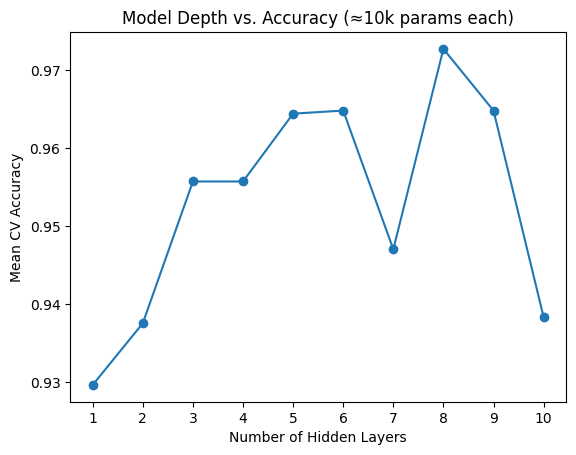

Best model depth: 8 hidden layers → mean CV accuracy = 0.9727


In [5]:
fig, ax = plt.subplots()
ax.plot(depths, mean_accuracies, '-o')
ax.set_xticks(depths)
ax.set_xlabel("Number of Hidden Layers")
ax.set_ylabel("Mean CV Accuracy")
ax.set_title("Model Depth vs. Accuracy (≈10k params each)")
plt.show()

# Find which depth gave the highest mean accuracy
best_idx = int(np.argmax(mean_accuracies))
best_depth = list(depths)[best_idx]
best_acc   = mean_accuracies[best_idx]

print(f"Best model depth: {best_depth} hidden layers → mean CV accuracy = {best_acc:.4f}")

In [6]:
LAYERS = best_depth
PARAMS = 10000

fold_metrics, histories, y_trues, y_preds, y_probs = cross_validate_dense(
    X, y,
    n_hidden_layers=LAYERS,
    param_budget=PARAMS,
    n_splits=10,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    patience=PATIENCE
)

Model: "sequential_50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_50 (Flatten)            │ (None, 390)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_325 (Dense)               │ (None, 18)             │         7,038 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_326 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_327 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_328 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_329 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_330 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_331 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_332 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_333 (Dense)               │ (None, 1)              │            19 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,355 (110.77 KB)

 Trainable params: 9,451 (36.92 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 18,904 (73.85 KB)

Model: "sequential_51"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_51 (Flatten)            │ (None, 390)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_334 (Dense)               │ (None, 18)             │         7,038 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_335 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_336 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_337 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_338 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_339 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_340 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_341 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_342 (Dense)               │ (None, 1)              │            19 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,355 (110.77 KB)

 Trainable params: 9,451 (36.92 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 18,904 (73.85 KB)

Model: "sequential_52"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_52 (Flatten)            │ (None, 390)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_343 (Dense)               │ (None, 18)             │         7,038 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_344 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_345 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_346 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_347 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_348 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_349 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_350 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_351 (Dense)               │ (None, 1)              │            19 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,355 (110.77 KB)

 Trainable params: 9,451 (36.92 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 18,904 (73.85 KB)

Model: "sequential_53"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_53 (Flatten)            │ (None, 390)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_352 (Dense)               │ (None, 18)             │         7,038 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_353 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_354 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_355 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_356 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_357 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_358 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_359 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_360 (Dense)               │ (None, 1)              │            19 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,355 (110.77 KB)

 Trainable params: 9,451 (36.92 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 18,904 (73.85 KB)

Model: "sequential_54"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_54 (Flatten)            │ (None, 390)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_361 (Dense)               │ (None, 18)             │         7,038 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_362 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_363 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_364 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_365 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_366 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_367 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_368 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_369 (Dense)               │ (None, 1)              │            19 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,355 (110.77 KB)

 Trainable params: 9,451 (36.92 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 18,904 (73.85 KB)

Model: "sequential_55"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_55 (Flatten)            │ (None, 390)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_370 (Dense)               │ (None, 18)             │         7,038 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_371 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_372 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_373 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_374 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_375 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_376 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_377 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_378 (Dense)               │ (None, 1)              │            19 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,355 (110.77 KB)

 Trainable params: 9,451 (36.92 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 18,904 (73.85 KB)

Model: "sequential_56"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_56 (Flatten)            │ (None, 390)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_379 (Dense)               │ (None, 18)             │         7,038 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_380 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_381 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_382 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_383 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_384 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_385 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_386 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_387 (Dense)               │ (None, 1)              │            19 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,355 (110.77 KB)

 Trainable params: 9,451 (36.92 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 18,904 (73.85 KB)

Model: "sequential_57"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_57 (Flatten)            │ (None, 390)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_388 (Dense)               │ (None, 18)             │         7,038 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_389 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_390 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_391 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_392 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_393 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_394 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_395 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_396 (Dense)               │ (None, 1)              │            19 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,355 (110.77 KB)

 Trainable params: 9,451 (36.92 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 18,904 (73.85 KB)

Model: "sequential_58"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_58 (Flatten)            │ (None, 390)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_397 (Dense)               │ (None, 18)             │         7,038 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_398 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_399 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_400 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_401 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_402 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_403 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_404 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_405 (Dense)               │ (None, 1)              │            19 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,355 (110.77 KB)

 Trainable params: 9,451 (36.92 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 18,904 (73.85 KB)

Model: "sequential_59"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_59 (Flatten)            │ (None, 390)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_406 (Dense)               │ (None, 18)             │         7,038 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_407 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_408 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_409 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_410 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_411 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_412 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_413 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_414 (Dense)               │ (None, 1)              │            19 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,355 (110.77 KB)

 Trainable params: 9,451 (36.92 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 18,904 (73.85 KB)

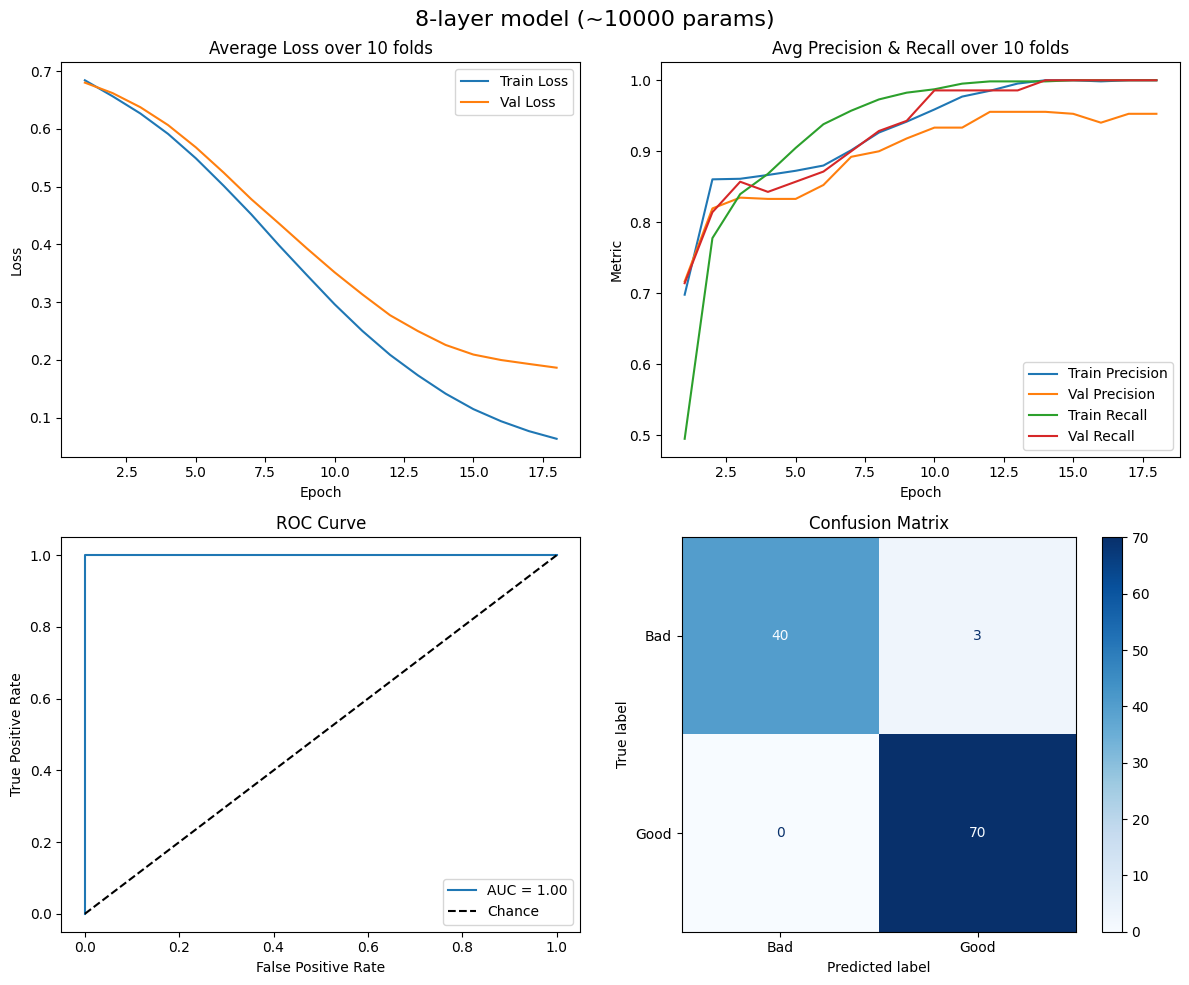

Mean CV metrics:
  Bce_Loss : 0.0802
  Accuracy : 0.9727
  Precision: 0.9653
  Recall   : 1.0000
  F1_Score : 0.9808
  Auc      : 1.0000


In [7]:
plot_cv_summary(histories, y_trues, y_preds, y_probs, LAYERS, PARAMS)
print_results(fold_metrics)

In [8]:
LAYERS = best_depth
PARAMS = 2000

fold_metrics, histories, y_trues, y_preds, y_probs = cross_validate_dense(
    X, y,
    n_hidden_layers=LAYERS,
    param_budget=PARAMS,
    n_splits=10,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    patience=PATIENCE
)

Model: "sequential_60"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_60 (Flatten)            │ (None, 390)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_415 (Dense)               │ (None, 4)              │         1,564 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_416 (Dense)               │ (None, 4)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_417 (Dense)               │ (None, 4)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_418 (Dense)               │ (None, 4)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_419 (Dense)               │ (None, 4)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_420 (Dense)               │ (None, 4)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_421 (Dense)               │ (None, 4)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_422 (Dense)               │ (None, 4)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_423 (Dense)               │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,129 (20.04 KB)

 Trainable params: 1,709 (6.68 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,420 (13.36 KB)

Model: "sequential_61"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_61 (Flatten)            │ (None, 390)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_424 (Dense)               │ (None, 4)              │         1,564 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_425 (Dense)               │ (None, 4)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_426 (Dense)               │ (None, 4)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_427 (Dense)               │ (None, 4)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_428 (Dense)               │ (None, 4)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_429 (Dense)               │ (None, 4)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_430 (Dense)               │ (None, 4)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_431 (Dense)               │ (None, 4)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_432 (Dense)               │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,129 (20.04 KB)

 Trainable params: 1,709 (6.68 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,420 (13.36 KB)

Model: "sequential_62"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_62 (Flatten)            │ (None, 390)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_433 (Dense)               │ (None, 4)              │         1,564 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_434 (Dense)               │ (None, 4)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_435 (Dense)               │ (None, 4)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_436 (Dense)               │ (None, 4)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_437 (Dense)               │ (None, 4)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_438 (Dense)               │ (None, 4)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_439 (Dense)               │ (None, 4)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_440 (Dense)               │ (None, 4)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_441 (Dense)               │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,129 (20.04 KB)

 Trainable params: 1,709 (6.68 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,420 (13.36 KB)

Model: "sequential_63"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_63 (Flatten)            │ (None, 390)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_442 (Dense)               │ (None, 4)              │         1,564 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_443 (Dense)               │ (None, 4)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_444 (Dense)               │ (None, 4)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_445 (Dense)               │ (None, 4)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_446 (Dense)               │ (None, 4)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_447 (Dense)               │ (None, 4)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_448 (Dense)               │ (None, 4)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_449 (Dense)               │ (None, 4)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_450 (Dense)               │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,129 (20.04 KB)

 Trainable params: 1,709 (6.68 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,420 (13.36 KB)

Model: "sequential_64"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_64 (Flatten)            │ (None, 390)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_451 (Dense)               │ (None, 4)              │         1,564 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_452 (Dense)               │ (None, 4)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_453 (Dense)               │ (None, 4)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_454 (Dense)               │ (None, 4)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_455 (Dense)               │ (None, 4)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_456 (Dense)               │ (None, 4)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_457 (Dense)               │ (None, 4)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_458 (Dense)               │ (None, 4)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_459 (Dense)               │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,129 (20.04 KB)

 Trainable params: 1,709 (6.68 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,420 (13.36 KB)

Model: "sequential_65"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_65 (Flatten)            │ (None, 390)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_460 (Dense)               │ (None, 4)              │         1,564 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_461 (Dense)               │ (None, 4)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_462 (Dense)               │ (None, 4)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_463 (Dense)               │ (None, 4)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_464 (Dense)               │ (None, 4)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_465 (Dense)               │ (None, 4)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_466 (Dense)               │ (None, 4)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_467 (Dense)               │ (None, 4)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_468 (Dense)               │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,129 (20.04 KB)

 Trainable params: 1,709 (6.68 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,420 (13.36 KB)

Model: "sequential_66"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_66 (Flatten)            │ (None, 390)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_469 (Dense)               │ (None, 4)              │         1,564 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_470 (Dense)               │ (None, 4)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_471 (Dense)               │ (None, 4)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_472 (Dense)               │ (None, 4)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_473 (Dense)               │ (None, 4)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_474 (Dense)               │ (None, 4)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_475 (Dense)               │ (None, 4)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_476 (Dense)               │ (None, 4)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_477 (Dense)               │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,129 (20.04 KB)

 Trainable params: 1,709 (6.68 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,420 (13.36 KB)

Model: "sequential_67"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_67 (Flatten)            │ (None, 390)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_478 (Dense)               │ (None, 4)              │         1,564 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_479 (Dense)               │ (None, 4)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_480 (Dense)               │ (None, 4)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_481 (Dense)               │ (None, 4)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_482 (Dense)               │ (None, 4)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_483 (Dense)               │ (None, 4)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_484 (Dense)               │ (None, 4)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_485 (Dense)               │ (None, 4)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_486 (Dense)               │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,129 (20.04 KB)

 Trainable params: 1,709 (6.68 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,420 (13.36 KB)

Model: "sequential_68"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_68 (Flatten)            │ (None, 390)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_487 (Dense)               │ (None, 4)              │         1,564 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_488 (Dense)               │ (None, 4)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_489 (Dense)               │ (None, 4)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_490 (Dense)               │ (None, 4)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_491 (Dense)               │ (None, 4)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_492 (Dense)               │ (None, 4)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_493 (Dense)               │ (None, 4)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_494 (Dense)               │ (None, 4)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_495 (Dense)               │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,129 (20.04 KB)

 Trainable params: 1,709 (6.68 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,420 (13.36 KB)

Model: "sequential_69"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_69 (Flatten)            │ (None, 390)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_496 (Dense)               │ (None, 4)              │         1,564 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_497 (Dense)               │ (None, 4)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_498 (Dense)               │ (None, 4)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_499 (Dense)               │ (None, 4)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_500 (Dense)               │ (None, 4)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_501 (Dense)               │ (None, 4)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_502 (Dense)               │ (None, 4)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_503 (Dense)               │ (None, 4)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_504 (Dense)               │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,129 (20.04 KB)

 Trainable params: 1,709 (6.68 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,420 (13.36 KB)

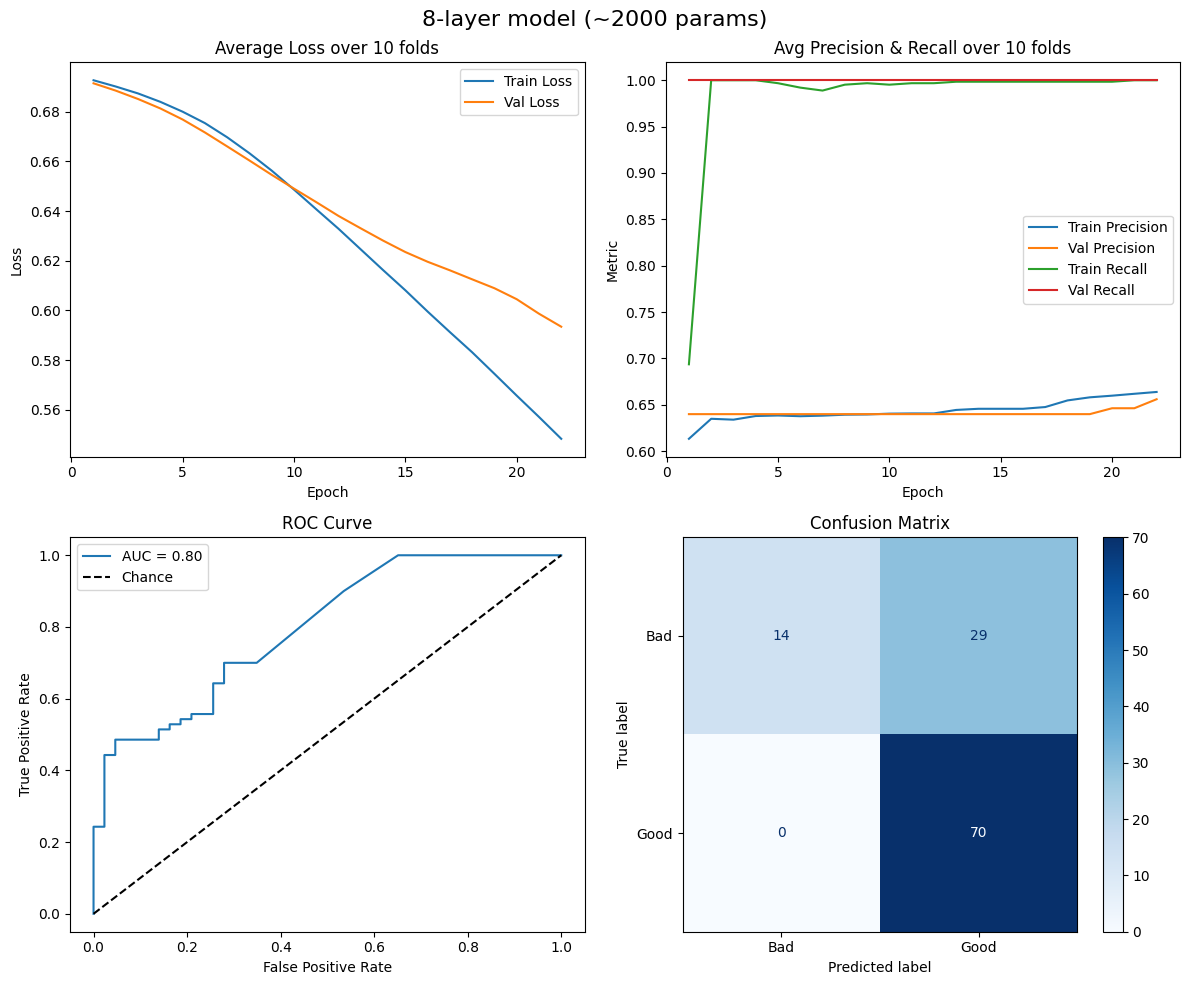

Mean CV metrics:
  Bce_Loss : 0.5174
  Accuracy : 0.7447
  Precision: 0.7337
  Recall   : 1.0000
  F1_Score : 0.8385
  Auc      : 0.7839


In [9]:
plot_cv_summary(histories, y_trues, y_preds, y_probs, LAYERS, PARAMS)
print_results(fold_metrics)

In [10]:
# ——— Final training on full dataset ———

# 1) Fit scaler on all of X
flat_all   = X.reshape(-1, X.shape[-1])
final_scaler = StandardScaler()
flat_scaled = final_scaler.fit_transform(flat_all)
X_scaled    = flat_scaled.reshape(X.shape)

# 2) Build final model
depth = best_depth
final_model = build_dense(
    n_hidden_layers=depth,
    param_budget=10_000,
    input_shape=(10, 39)
)

# 3) Train on the full, scaled dataset
final_model.fit(
    X_scaled, y,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)

# 4) Save both model and scaler
final_model.save(os.path.join("models", "kinect_dense_good_vs_bad_model.keras"))
dump(final_scaler, os.path.join("models", "kinect_dense_good_vs_bad_scaler.pkl"))
final_model.summary()
print("Model and scaler saved successfully!")

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6280 - auc: 0.2185 - loss: 0.7261 - precision: 0.6280 - recall: 1.0000
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6530 - auc: 0.6703 - loss: 0.6407 - precision: 0.6530 - recall: 1.0000
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6270 - auc: 0.9286 - loss: 0.5996 - precision: 0.6270 - recall: 1.0000 
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6426 - auc: 0.9601 - loss: 0.5428 - precision: 0.6426 - recall: 1.0000 
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6655 - auc: 0.9733 - loss: 0.4710 - precision: 0.6655 - recall: 1.0000 
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6082 - auc: 0.9895 - loss: 0.4619 - precision: 0.6082 - recall: 1.0000 
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6280 - auc: 0.9950 - loss: 0.4120 - precision: 0.6280 - recall: 1.0000 
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.

Model: "sequential_70"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_70 (Flatten)            │ (None, 390)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_505 (Dense)               │ (None, 18)             │         7,038 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_506 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_507 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_508 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_509 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_510 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_511 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_512 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_513 (Dense)               │ (None, 1)              │            19 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,355 (110.77 KB)

 Trainable params: 9,451 (36.92 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 18,904 (73.85 KB)

Model and scaler saved successfully!
